In [ ]:
%matplotlib inline

In [1]:
#Mount the Drive
from google.colab import drive

drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [2]:
import sys
S7_PROJECT_PATH = '/content/drive/MyDrive/CVMODEL/DEPTHSEP/'
sys.path.append(S7_PROJECT_PATH)
import os
#os.chdir(S7_PROJECT_PATH+'/Model/')

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# # Import Transform Module

In [4]:

sys.path.append ('/content/drive/MyDrive/CVMODEL/DEPTHSEP/TransForm/')
from datatransform import Transforms

common_transforms = Transforms(normalize=False, mean=None, stdev=None)


## Load Data and Calculate Mean and STD

In [5]:
sys.path.append ('/content/drive/MyDrive/CVMODEL/DEPTHSEP/DataLoader/')
from getdata import DataLoader
from torchvision import datasets, transforms
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=common_transforms.train_transforms())
# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=common_transforms.test_transforms())

# Calculating Mean and Std dev
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = trainset.data
#train_data = trainset.transform(train_data.numpy())

test_data = testset.data

full_data = np.concatenate((train_data, test_data),axis=0)

full_data.reshape(-1,full_data.shape[-1])

mean=full_data.reshape(-1,full_data.shape[-1]).mean(0)/255

std=full_data.reshape(-1,full_data.shape[-1]).std(0)/255

print(full_data[0].shape)
print(mean)
print(std)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
(32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


## Transform data and create a data loader

In [6]:
SEED = 1

updated_transforms= Transforms(normalize=True, mean=(0.49186878, 0.48265391, 0.44717728), stdev=(0.24697121, 0.24338894, 0.26159259))

# Downloading TrainSet
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=updated_transforms.train_transforms())

# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=updated_transforms.test_transforms())

# Creating object of a class
dataloader= DataLoader(shuffle=True, batch_size=64, seed=SEED, num_workers=2, pin_memory=True)


# train data loader
trainloader = dataloader.load(trainset)

# test data loader
testloader = dataloader.load(testset)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


## Checks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse plane  deer   car


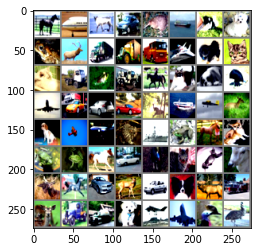

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Import Model and create model class

In [8]:
sys.path.append('/content/drive//MyDrive/CVMODEL/DEPTHSEP/Model/')

from model import Cfar10Net
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Cfar10Net(dropout_value=0.1).to(device)

summary(model,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,432
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

## Run Model

In [11]:

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
Loss="CrossEntropyLoss"
EPOCHS = 20
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, epochs=EPOCHS, statspath=S7_PROJECT_PATH+"Save_Model", scheduler=None, batch_scheduler=False, L1lambda=0, LossType=Loss)


Validation loss decreased (100000.000000 --> 0.991584).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0122, Accuracy: 72.50%; Test set: Average loss: 0.9916, Accuracy: 71.63%



Validation loss decreased (0.991584 --> 0.930240).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0111, Accuracy: 75.22%; Test set: Average loss: 0.9302, Accuracy: 74.05%



Validation loss decreased (0.930240 --> 0.856740).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0101, Accuracy: 77.30%; Test set: Average loss: 0.8567, Accuracy: 75.76%



Validation loss decreased (0.856740 --> 0.826205).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0094, Accuracy: 79.08%; Test set: Average loss: 0.8262, Accuracy: 77.19%



Epoch: 5, Train set: Average loss: 0.0087, Accuracy: 80.55%; Test set: Average loss: 0.8338, Accuracy: 77.92%



Validation loss decreased (0.826205 --> 0.762347).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0081, Accuracy: 81.78%; Test set: Average loss: 0.7623, Accuracy: 78.95%



Validation loss decreased (0.762347 --> 0.758214).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0077, Accuracy: 82.71%; Test set: Average loss: 0.7582, Accuracy: 79.03%



Epoch: 8, Train set: Average loss: 0.0072, Accuracy: 84.08%; Test set: Average loss: 0.8001, Accuracy: 79.03%



Validation loss decreased (0.758214 --> 0.752835).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0068, Accuracy: 84.77%; Test set: Average loss: 0.7528, Accuracy: 79.43%



Validation loss decreased (0.752835 --> 0.750657).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0064, Accuracy: 85.68%; Test set: Average loss: 0.7507, Accuracy: 79.74%



Validation loss decreased (0.750657 --> 0.744974).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0061, Accuracy: 86.52%; Test set: Average loss: 0.7450, Accuracy: 80.13%



Epoch: 12, Train set: Average loss: 0.0057, Accuracy: 87.48%; Test set: Average loss: 0.7500, Accuracy: 80.38%



Epoch: 13, Train set: Average loss: 0.0054, Accuracy: 88.06%; Test set: Average loss: 0.7546, Accuracy: 80.17%



Validation loss decreased (0.744974 --> 0.718066).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0052, Accuracy: 88.36%; Test set: Average loss: 0.7181, Accuracy: 81.56%



Epoch: 15, Train set: Average loss: 0.0048, Accuracy: 89.28%; Test set: Average loss: 0.7325, Accuracy: 81.23%



Epoch: 16, Train set: Average loss: 0.0046, Accuracy: 89.87%; Test set: Average loss: 0.7244, Accuracy: 81.35%



Epoch: 17, Train set: Average loss: 0.0043, Accuracy: 90.47%; Test set: Average loss: 0.7338, Accuracy: 81.35%



Validation loss decreased (0.718066 --> 0.691299).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0041, Accuracy: 90.86%; Test set: Average loss: 0.6913, Accuracy: 82.24%



Epoch: 19, Train set: Average loss: 0.0038, Accuracy: 91.60%; Test set: Average loss: 0.7549, Accuracy: 81.91%



Epoch: 20, Train set: Average loss: 0.0036, Accuracy: 92.05%; Test set: Average loss: 0.7026, Accuracy: 82.39%

